In [193]:
import re
import nltk
import string
import xgboost as XGBClassifier
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from nltk import FreqDist
import plotly.express as px
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import TweetTokenizer
from nltk.corpus import stopwords
import sklearn.preprocessing as pr
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from keras.metrics import Precision, Recall
from sklearn.preprocessing import LabelEncoder
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve


warnings.filterwarnings('ignore')

In [2]:
!ls Data

tweets.csv


In [3]:
df = pd.read_csv('Data/tweets.csv', encoding = 'iso-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.tail(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [5]:
df.shape

(9093, 3)

In [6]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [7]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [9]:
# Rename column names
col_names = ['Tweets','Product/Brand','Sentiment']

In [10]:
df = df.set_axis(col_names, axis=1, inplace=False)

In [11]:
df['Sentiment'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [12]:
df['Product/Brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

### Data Cleaning

In [13]:
df[df['Tweets'].isna()]

,Tweets,Product/Brand,Sentiment
6,NaN,NaN,No emotion toward brand or product


In [14]:
# We have only one missing tweets in Tweets so will go ahead and drop it
df = df[df['Tweets'].isna() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweets         9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [15]:
df[df['Product/Brand'].isna()].head()

,Tweets,Product/Brand,Sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [16]:
df['Product/Brand'].isna().sum()

5801

In [17]:
# The tweets above are not directed toward a specific product/brand.
# So,we will go ahead and fill it with Unknown.
df['Product/Brand'].fillna('N/A', inplace=True)

In [18]:
df.isna().sum()

Tweets           0
Product/Brand    0
Sentiment        0
dtype: int64

In [19]:
# Looks good, we don't have any missing data.

In [20]:
df['Sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Sentiment, dtype: int64

In [21]:
# Changing sentiment names to Positive, Negative, Neutral & Unknown.
sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['Sentiment'] = df['Sentiment'].map(sentiment_dict)
df.head()

,Tweets,Product/Brand,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [22]:
df['Sentiment'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Unknown      156
Name: Sentiment, dtype: int64

In [23]:
# Checking tweets with unknown sentiments to see if we could find a pattern to whether the tweet has a 
# Negative, Neutral, or positive Sentiment.

pd.set_option("display.max_colwidth", 300)
df[df['Sentiment']=='Unknown']

,Tweets,Product/Brand,Sentiment
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,N/A,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,N/A,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",N/A,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,N/A,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},N/A,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,N/A,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",N/A,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",N/A,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,N/A,Unknown


In [24]:
# The Unknown tweets doesn't seem to have any sentiment so we will go ahead and drop the unknown row.
df = df[df['Sentiment']!='Unknown']
df['Sentiment'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: Sentiment, dtype: int64

In [25]:
# Checking & addressing duplicates
len(df[df.duplicated()])

22

In [26]:
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweets         8914 non-null   object
 1   Product/Brand  8914 non-null   object
 2   Sentiment      8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


<AxesSubplot: xlabel='Sentiment', ylabel='count'>

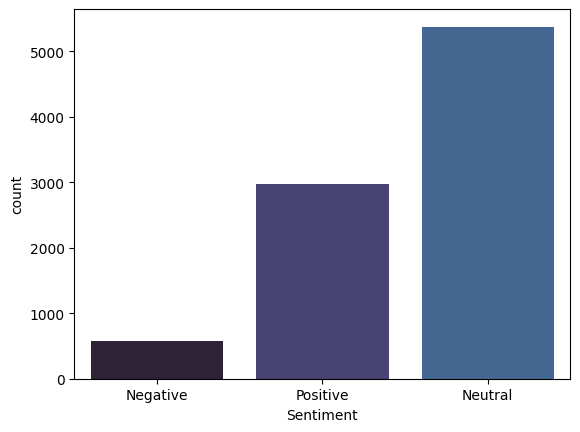

In [27]:
palette = sns.set_palette(sns.color_palette("mako"))
sns.countplot(x = df["Sentiment"], color = palette)

In [40]:
fig = px.pie(df, names = 'Sentiment', color = 'Sentiment',
             color_discrete_map = {'Positive':'green',
                                   'Negative':'Darkred',
                                   'Neutral':'orange'})
fig.show()

### Exploritory Data Analysis

#### Tweets with positive sentiments

In [41]:
df_pos = df[df['Sentiment']=='Positive']
corpus_pos = df_pos['Tweets'].to_list()
corpus_pos[:1]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"]

In [42]:
# function tokenization of tweets
def tokenize_tweets(corpus, preserve_case=False, strip_handles=True):
#    Function returns tokens based on a corpus passed in. The corpus will be broken 
#    down into tokens based on TweetTokenizer from the nltk package.
   
    
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    tokens = tokenizer.tokenize(','.join(corpus))
    return tokens

In [43]:
def find_frequent(tokens, n=50):
# Function returns the n most common words along with their frequencies 
# based on a tokens list passed in.
    
    freq = FreqDist(tokens)
    display(freq.most_common(n))

In [44]:
find_frequent(df_pos)

[('Tweets', 1), ('Product/Brand', 1), ('Sentiment', 1)]

In [45]:
# Tokenize positive tweets
tokens_pos = tokenize_tweets(corpus_pos)

In [46]:
# Checking most common token 
freq = FreqDist(tokens_pos)
freq.most_common(5)

[(',', 4050), ('#sxsw', 2983), ('.', 2230), ('the', 1590), ('!', 1241)]

#### Lemmatization

In [47]:
def lemmatize_tokens(tokens_list):
# Function lemmatizes tokens list.

    lemmatizer = WordNetLemmatizer()
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm

In [48]:
tokens_pos_lemm = lemmatize_tokens(tokens_pos)

In [49]:
# Displaying most common tokens
freq = FreqDist(tokens_pos_lemm)
freq.most_common(5)

[(',', 4050), ('#sxsw', 2983), ('.', 2230), ('the', 1590), ('!', 1241)]

#### Removing Stop Words & Punctuations

In [50]:
# Removing Stop Words and Punctuations.

stop_w = stopwords.words('english')
stop_w += list(string.punctuation)

# Adding additional characters and empty string to stop words
punct = ['“','”','...',"''",'’','``','','#sxsw', '#sxswi', 'sxsw']
stop_w += punct

In [51]:
def remove_stop(tokens, stop_words = stop_w):
    
# Function removes stop words from a given tokens list based on a stop word list.
    
# Encoding/decoding tokens to eliminate unrecognized symbols and 
# Eliminating external links.

    tokens_stopped = [word.encode('ascii','ignore').decode() 
                      for word in tokens 
                      if (word not in stop_words) & 
                      (word.startswith('http') == False)]
    
    return tokens_stopped

In [52]:
# Removing stop words from lemmatized tokens
tokens_pos_ls = remove_stop(tokens_pos_lemm)

In [53]:
# Checking if stop words has been removed
freq = FreqDist(tokens_pos_ls)
freq.most_common(5)

[('link', 1218), ('ipad', 1010), ('rt', 931), ('apple', 711), ('google', 602)]

In [54]:
# Function to check whether a words has a given context

def context_finder(word, corpus, n_samples=5, n_count=5):
    """This function takes n_samples with each sample having 
    n_count tweets from the given corpus, and displays tweets that 
    have the specified word in them. The goal of the function is to get 
    some context about a word."""
    
    i = 0
    
    for _ in list(range(0,n_samples)):
        sample = np.random.choice(corpus, n_count)
        for tweet in sample:
            if word in tweet:
                print(tweet)
                i += 1
    print('-----------------------------------')
    print(f'Out of {n_count*n_samples} tweets analyzed,\
    {i} tweets had the word "{word}" in them.')

In [55]:
stop_w += ['link']

In [56]:
stop_w += ['rt']

In [57]:
tokens_pos_ls = remove_stop(tokens_pos_ls, stop_words = stop_w)

In [58]:
# Defining a function to find the n most common tokens

def find_frequent(tokens, n = 10):
    """Function returns the n most common words along with their frequencies 
    based on a tokens list passed in.
    -------------------------------
    Arguments:
    tokens: a tokens list
    n: number of top words to be returned"""
    
    freq = FreqDist(tokens)
    display(freq.most_common(n))

In [59]:
find_frequent(tokens_pos_ls)

[('ipad', 1010),
 ('apple', 711),
 ('google', 602),
 ('2', 595),
 ('store', 554),
 ('iphone', 466),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181)]

In [98]:
# Defining a function for wordcloud generation
def generate_wordcloud(tokens, collocations = False, background_color = 'black', 
                       colormap ='Greens', display = True):
    
#    Function generates and returns a wordcloud based on a tokens list passed in.

    
# Initalize a WordCloud
    wordcloud = WordCloud(collocations = collocations, 
                          background_color = background_color, 
                          colormap = colormap, 
                          width = 500, height = 300)

# Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

# Plot with matplotlib
    if display:
        plt.figure(figsize = (10, 10), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
    return wordcloud

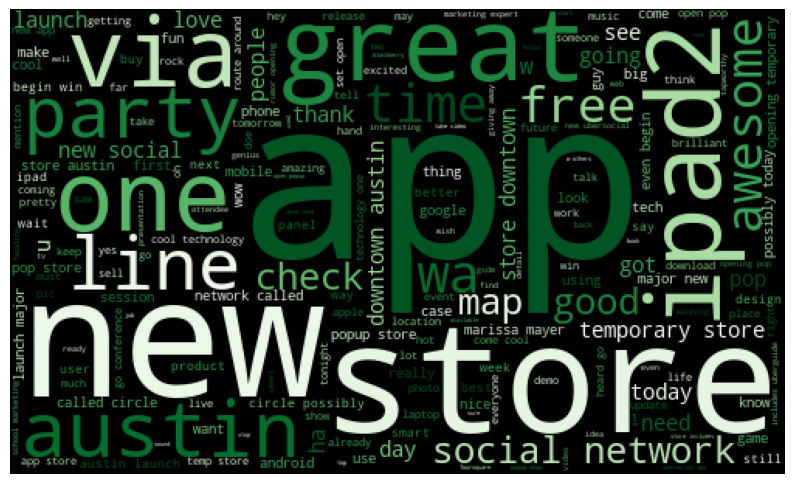

In [99]:
# Word cloud with company / product names
cloud_pos_w_com = generate_wordcloud(tokens_pos_ls, collocations = True)

In [85]:
# Removing product/company names
stop_words_no_comp = stop_w + ['ipad', 'apple', 'google', 'iphone', '#apple', 
                               '#google', '#ipad', '#iphone', 'android']
tokens_pos_ls = remove_stop(tokens_pos_ls, stop_words = stop_words_no_comp)

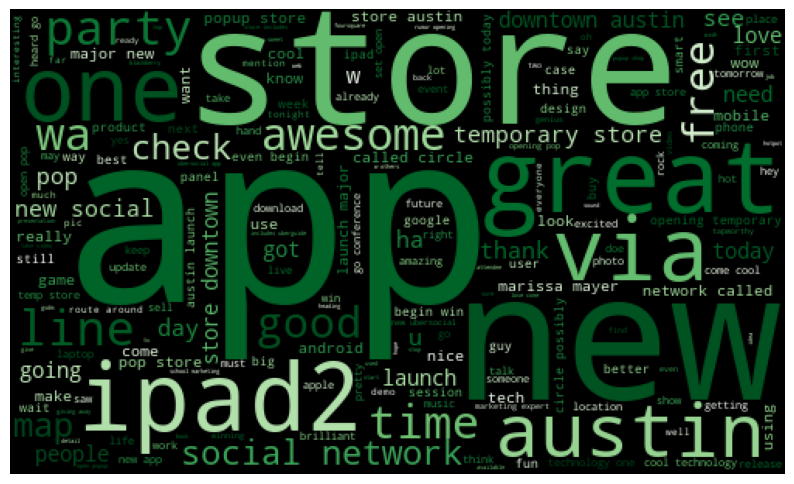

In [86]:
# Word cloud without company / product names
cloud_pos_wo_comp = generate_wordcloud(tokens_pos_ls, collocations = True)

#### Tweets with negative sentiments

In [71]:
df_neg = df[df['Sentiment']=='Negative']
corpus_neg = df_neg['Tweets'].to_list()
corpus_neg[:1]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.']

In [72]:
# Tokenize negative tweets
tokens_neg = tokenize_tweets(corpus_neg)

# Lemmatize negative tweets.
tokens_neg_lemm = lemmatize_tokens(tokens_neg)

# Removing stop words & punctuation using the same stop words list
tokens_neg_ls = remove_stop(tokens_neg_lemm, stop_words = stop_w)

In [73]:
# Checking for most common words
find_frequent(tokens_neg_ls)

[('ipad', 179),
 ('iphone', 145),
 ('google', 136),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43)]

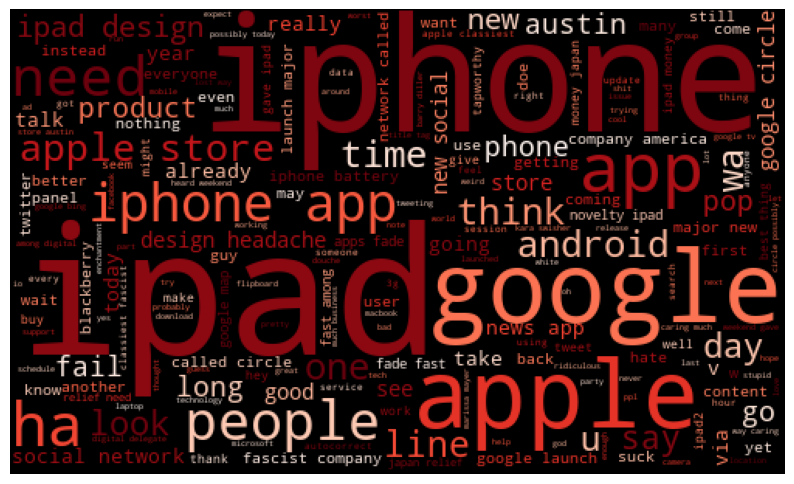

In [74]:
# Word cloud with company / product names
cloud_neg_w_company = generate_wordcloud(tokens_neg_ls, colormap = 'Reds', 
                                         collocations = True)

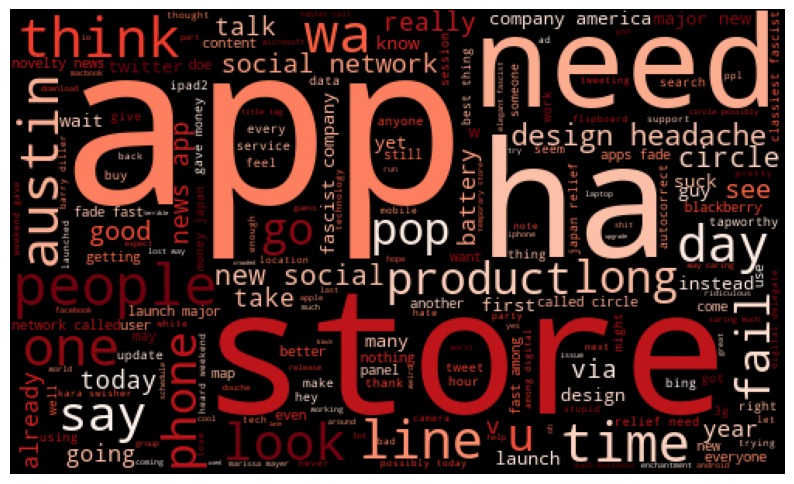

In [75]:
# Removing company/product information from the tokens
tokens_neg_ls = remove_stop(tokens_neg_ls, stop_words = stop_words_no_comp)

# Word cloud without company / product names
cloud_neg_wo_company = generate_wordcloud(tokens_neg_ls, colormap = 'Reds', 
                                          collocations=True)

In [76]:
# Tweets with Neutral Sentiments
df_neut = df[df['Sentiment']=='Neutral']
corpus_neut = df_neut['Tweets'].to_list()
corpus_neut[:1]

['@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd']

In [77]:
tokens_neut = tokenize_tweets(corpus_neut)

# Lemmatize negative tweets.
tokens_neut_lemm = lemmatize_tokens(tokens_neut)

# Removing stop words & punctuation using the same stop words list
tokens_neut_ls = remove_stop(tokens_neut_lemm, stop_words = stop_w)

In [78]:
find_frequent(tokens_neut_ls)

[('google', 1344),
 ('ipad', 1178),
 ('', 1014),
 ('apple', 968),
 ('store', 893),
 ('2', 677),
 ('new', 671),
 ('iphone', 667),
 ('austin', 557),
 ('launch', 476)]

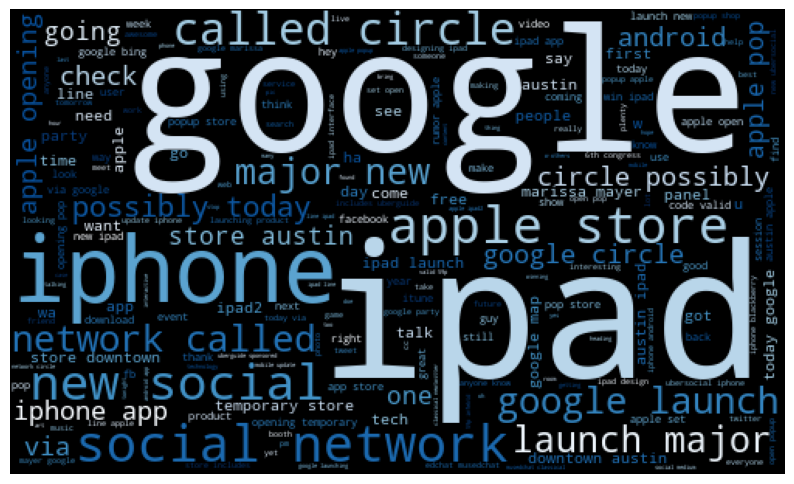

In [87]:
# Word cloud of Neutral Sentiments with company / product names
cloud_neut_w_company = generate_wordcloud(tokens_neut_ls, colormap = 'Blues', 
                                         collocations = True)

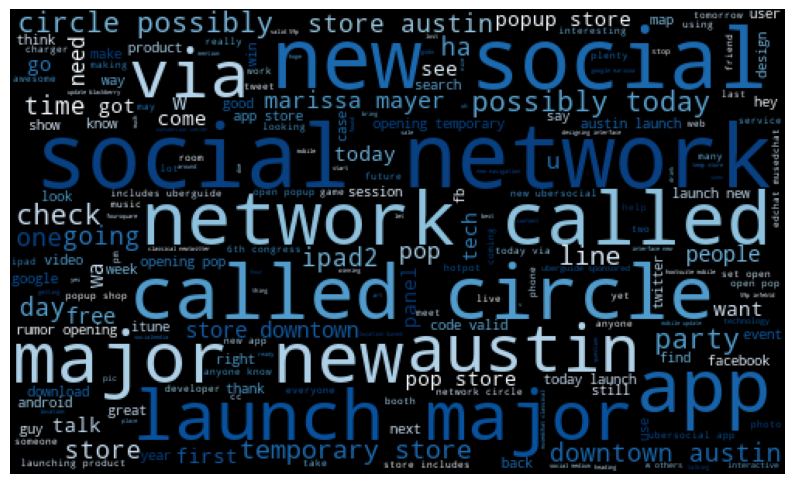

In [89]:
# Removing company/product information from the tokens
tokens_neut_ls = remove_stop(tokens_neut_ls, stop_words = stop_words_no_comp)

# Word cloud without company / product names
cloud_neut_wo_company = generate_wordcloud(tokens_neut_ls, colormap = 'Blues', 
                                          collocations=True)

### Sentiment Analysis Model

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [115]:
def multiclass_eval(y_true, y_pred, X_test, X_train, clf, n_class=3):

# This function shows the classification report, the confusion matrix as well 
#    as the ROC curve for evaluation of model quality for multiclass models.
    

    
# Training and test scores
    print(f"Training Score: {round(clf.score(X_train, y_train),2)} \
            Test Score:{round(clf.score(X_test, y_true),2)}")
    
# Classification report
    print("\n")
    print("CLASSIFICATION REPORT")
    print("------------------------------------------")
    print(classification_report(y_true = y_true, y_pred = y_pred))
    
# Creating a figure/axes for confusion matrix and ROC curve
    fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
    
# Plotting the normalized confusion matrix
    plot_confusion_matrix(estimator = clf, X = X_test, y_true = y_true, cmap = 'Blues', 
                          normalize = 'true', ax = ax[0], 
                          display_labels = ['Negative', 'Neutral', 'Positive'])
    
    pred_prob = clf.predict_proba(X_test)
    
# Plotting the ROC curve
    fpr = {}
    tpr = {}
    thresh = {}
    
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, pred_prob[:,i], pos_label=i)
    
    ax[1].plot(fpr[0], tpr[0], linestyle = '--',color = 'red', label = 'Negative vs Rest')
    ax[1].plot(fpr[1], tpr[1], linestyle = '--',color = 'blue', label = 'Neutral vs Rest')
    ax[1].plot(fpr[2], tpr[2], linestyle = '--',color = 'green', label = 'Positive vs Rest')
    ax[1].set_title('Multiclass ROC curve')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive rate')
    ax[1].legend(loc = 'best')
    
# Plotting the 50-50 guessing plot for reference
    ax[1].plot([0,1], [0,1], ls = '--', color = 'orange')

#### Train-Test Split

In [117]:
# Changing sentiment column to numerical values.
sentiment_dict = {'Negative': 0, 'Neutral':1, 'Positive': 2}
df['Sentiment'] = df['Sentiment'].map(sentiment_dict)
df['Sentiment'].value_counts()

1    5375
2    2970
0     569
Name: Sentiment, dtype: int64

In [119]:
# Defining targets

y = df['Sentiment']
X = df['Tweets']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [120]:
y_train.value_counts(normalize=True)

1    0.604338
2    0.333732
0    0.061930
Name: Sentiment, dtype: float64

In [121]:
def multiclass_eval(y_true, y_pred, X_test, X_train, clf, n_class = 3):
# This function shows the classification report, the confusion matrix as well as 
# the ROC curve for evaluation of model quality for multiclass models.

    
# Training and test scores
    print(f"Training Score: {round(clf.score(X_train, y_train),2)} \
            Test Score:{round(clf.score(X_test, y_true),2)}")
    
# Classification report
    print("\n")
    print("CLASSIFICATION REPORT")
    print("------------------------------------------")
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
# Confusion matrix and ROC curve figure
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
# Plotting the normalized confusion matrix.
    plot_confusion_matrix(estimator = clf, X = X_test, y_true = y_true, cmap = 'Blues', 
                          normalize = 'true', ax = ax[0], 
                          display_labels = ['Negative', 'Neutral', 'Positive'])
    
    pred_prob = clf.predict_proba(X_test)
    
# Plotting the ROC curve
    fpr = {}
    tpr = {}
    thresh = {}
    
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, pred_prob[:,i], pos_label = i)
    
    ax[1].plot(fpr[0], tpr[0], linestyle = '--',color = 'red', label = 'Negative vs Rest')
    ax[1].plot(fpr[1], tpr[1], linestyle = '--',color = 'blue', label = 'Neutral vs Rest')
    ax[1].plot(fpr[2], tpr[2], linestyle = '--',color = 'green', label = 'Positive vs Rest')
    ax[1].set_title('Multiclass ROC curve')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive rate')
    ax[1].legend(loc='best')
    
# Plotting the 50-50 guessing plot for reference
    ax[1].plot([0,1], [0,1], ls = '--', color = 'orange')

#### First Model Random Forest

In [173]:
# We will use the NLTK nltk.TweetTokenizer() method to convert the stream of words into small tokens.
tokenizer = TweetTokenizer(preserve_case = False, strip_handles = True)

Training Score: 0.96             Test Score:0.68


CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.20      0.31       155
           1       0.70      0.84      0.76      1335
           2       0.61      0.49      0.54       739

    accuracy                           0.68      2229
   macro avg       0.66      0.51      0.54      2229
weighted avg       0.67      0.68      0.66      2229



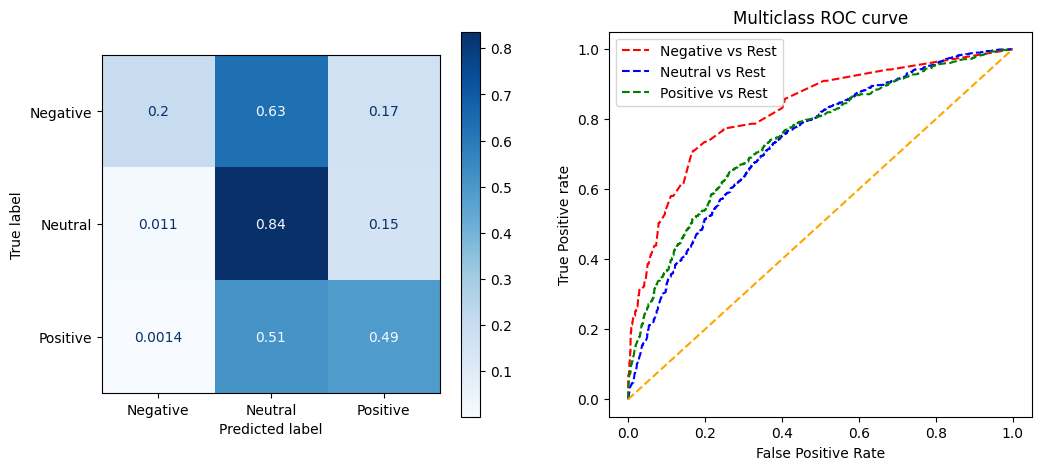

In [174]:
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = tokenizer.tokenize, 
                                   stop_words = stop_w)), 
    ('clf', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

As showing above scores. It looks like our results is overfitting in the training dataset. So, we will go ahead and tune our model using Grid Search to see if it will improve our model performance.

In [206]:
param_grid = {'clf__criterion': ['gini', 'entropy'], 
            'clf__max_depth': [10, 20, None],
            'clf__min_samples_leaf': [1, 2, 3]}

gridsearch = GridSearchCV(estimator = clf_pipe, param_grid = param_grid, 
                              scoring = 'precision')

gridsearch.fit(X_train,  y_train)
gridsearch.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1}

### Tuned Random Forest Model

Training Score: 0.69             Test Score:0.59


CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.25      0.35      0.30       155
           1       0.75      0.59      0.66      1335
           2       0.49      0.64      0.56       739

    accuracy                           0.59      2229
   macro avg       0.50      0.53      0.50      2229
weighted avg       0.63      0.59      0.60      2229



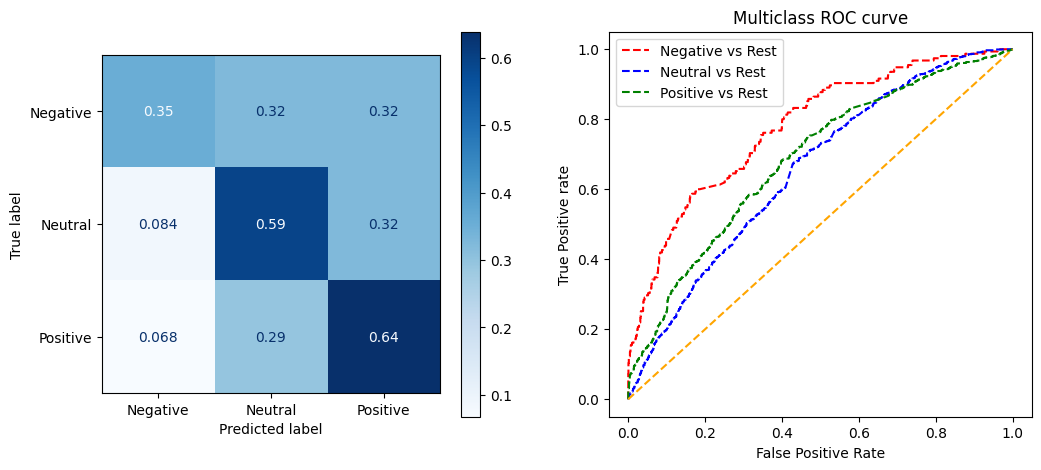

In [208]:
clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = tokenizer.tokenize, 
                                   stop_words = stop_w)),
    ('clf', RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', 
                                   max_depth = 10, min_samples_leaf = 1, random_state = 23))
])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe)

In [133]:
# The model is doing much better compared to the previous ones. Its still overfit but not by much.

### Logistice Regression Model

Training Score: 0.83             Test Score:0.65


CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

           0       0.36      0.49      0.41       155
           1       0.78      0.66      0.72      1335
           2       0.56      0.66      0.60       739

    accuracy                           0.65      2229
   macro avg       0.56      0.60      0.58      2229
weighted avg       0.67      0.65      0.66      2229



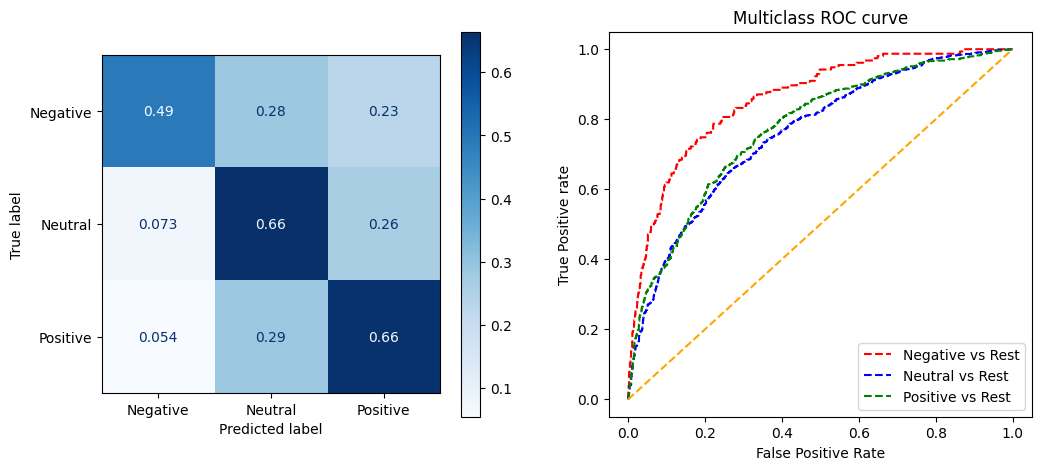

In [176]:
clf_pipe_tuned_LR_multi = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = tokenizer.tokenize, 
                                   stop_words = stop_w)), 
    ('clf', LogisticRegressionCV(class_weight = 'balanced', random_state=42, 
                                 cv = 2, solver ='sag', max_iter = 100, Cs = [1]))
])

clf_pipe_tuned_LR_multi.fit(X_train, y_train)
y_pred = clf_pipe_tuned_LR_multi.predict(X_test)
multiclass_eval(y_test, y_pred, X_test, X_train, clf_pipe_tuned_LR_multi)

In [177]:
# The second model looks better but still its overfitting in the training dataset.